In [1]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

In [2]:
dataset = fetch_openml("mnist_784")

In [3]:
device = "cuda"

In [4]:
data, target = dataset.data.to_numpy() / 255., dataset.target.to_numpy()
data = torch.FloatTensor(data).to(device)
target = torch.Tensor([int(i) for i in target]).long().to(device)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True)

In [6]:
from torch.utils.data import Dataset

class CustomerDataset(Dataset):
  def __init__(self, data, target):
    self.data = data
    self.target = target
  
  def __len__(self):
    return len(self.data)
  
  def __getitem__(self, idx):
    return self.data[idx], self.target[idx]

In [7]:
from torch.utils.data import DataLoader

train_dataset = CustomerDataset(X_train, y_train)
val_dataset = CustomerDataset(X_val, y_val)
test_dataset = CustomerDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64)
val_dataloader = DataLoader(val_dataset, batch_size=64)
test_dataloader = DataLoader(test_dataset, batch_size=64)

In [27]:
import matplotlib.pyplot as plt

def test_model(model, dataloader):
  count = 0
  dataloader_size = len(dataloader) if len(dataloader) <= 20 else 20
  
  plt.figure(figsize=(8, 8 * dataloader_size))
  for i, (X, y) in enumerate(dataloader):
    model.eval()
    with torch.no_grad():
      pred = model(X)
      pred_ = torch.argmax(pred, dim=1)
      count += (pred_ == y).sum()

    if i < 20:
      plt.subplot(dataloader_size, 1, i+1)
      plt.title(f"Answer : {y[0]} / Prediction : {pred_[0]}")
      plt.imshow(X[0].to("cpu").view(28, 28))
  return count, len(dataloader.dataset)

In [22]:
class FullConnectedModel(nn.Module):
  def __init__(self):
    super(FullConnectedModel, self).__init__()
    self.layer1 = nn.Linear(784, 512)
    self.activate1 = nn.ReLU()
    self.layer2 = nn.Linear(512, 512)
    self.activate2 = nn.ReLU()
    self.layer3 = nn.Linear(512, 10)
  
  def forward(self, X):
    out = self.layer1(X)
    out = self.activate1(out)
    out = self.layer2(out)
    out = self.activate2(out)
    out = self.layer3(out) 
    return out
model = FullConnectedModel().cuda()

In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
loss_fn = torch.nn.CrossEntropyLoss().to(device)

In [25]:
epochs = 25
train_losses = []
val_losses = []
for epoch in range(epochs):
  print(f"Epoch {epoch+1} / {epochs} ====")
  temp_loss = 0.
  model.train()
  for X, y in train_dataloader:
    pred = model.forward(X)
    loss = loss_fn(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    temp_loss += loss.item()
  temp_loss /= len(train_dataloader)
  train_losses.append(temp_loss)

  temp_loss = 0.
  model.eval()
  for X, y in val_dataloader:
    with torch.no_grad():
      pred = model.forward(X)
      loss = loss_fn(pred, y)
      temp_loss += loss.item()
  temp_loss /= len(val_dataloader)
  val_losses.append(temp_loss)
  

Epoch 1 / 25 ====
Epoch 2 / 25 ====
Epoch 3 / 25 ====
Epoch 4 / 25 ====
Epoch 5 / 25 ====
Epoch 6 / 25 ====
Epoch 7 / 25 ====
Epoch 8 / 25 ====
Epoch 9 / 25 ====
Epoch 10 / 25 ====
Epoch 11 / 25 ====
Epoch 12 / 25 ====
Epoch 13 / 25 ====
Epoch 14 / 25 ====
Epoch 15 / 25 ====
Epoch 16 / 25 ====
Epoch 17 / 25 ====
Epoch 18 / 25 ====
Epoch 19 / 25 ====
Epoch 20 / 25 ====
Epoch 21 / 25 ====
Epoch 22 / 25 ====
Epoch 23 / 25 ====
Epoch 24 / 25 ====
Epoch 25 / 25 ====


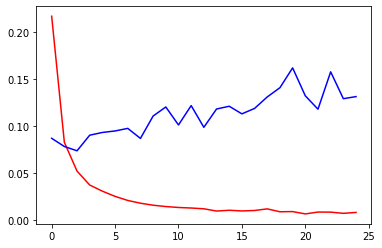

In [26]:
import matplotlib.pyplot as plt

plt.plot(train_losses, c="red")
plt.plot(val_losses, c="blue")
plt.show()

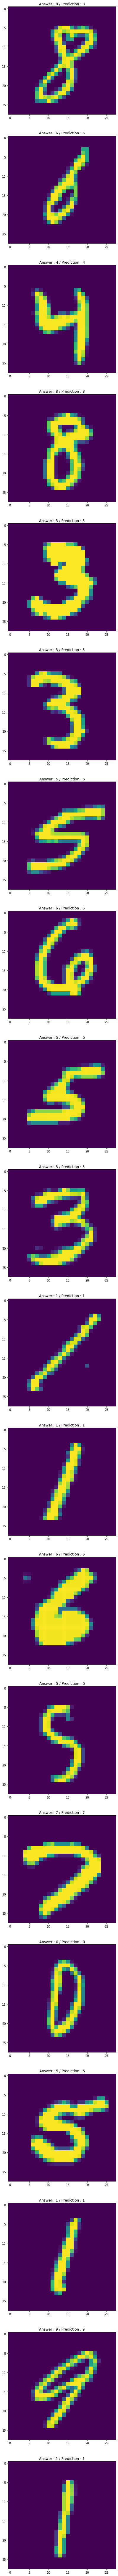

In [28]:
correct_count, total_count = test_model(model, test_dataloader)

In [29]:
print(f"{correct_count} / {total_count} ({(correct_count / total_count * 100):4.2f})")

3431 / 3500 (98.03)
